# Build Base Model (Logistic Regression)

In this notebook, I will build a base line model. The ultimate goal of the project is to build a model that takes a new-born infant's and its parents' data and predict whether the baby dies or not. First, it is necessarry to encode the categorical features in the cleaned data, before applying machine learning algoriths such as logistic regression, support vector machine, etc.

In [1]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
Data_2008 = pd.read_pickle('CleanData_ML_UC')

In [3]:
Data_2008.rename(columns=lambda x: x.strip(),inplace = True)

In [4]:
attribute_list = list(Data_2008.columns.str.strip()) #strip in case some of the column names have spaces around them.
print(attribute_list)

['AB_ANTI', 'AB_AVEN1', 'AB_AVEN6', 'AB_BINJ', 'AB_NICU', 'AB_SEIZ', 'AB_SURF', 'APGAR5', 'ATTEND', 'BFACIL', 'BRTHWGT', 'CA_ANEN', 'CA_CCHD', 'CA_CDH', 'CA_CLEFT', 'CA_CLPAL', 'CA_DISOR', 'CA_DOWN', 'CA_GAST', 'CA_HYPO', 'CA_LIMB', 'CA_MNSB', 'CA_OMPH', 'CIG_1', 'CIG_2', 'CIG_3', 'CIG_REC', 'COMBGEST', 'DMETH_REC', 'DPLURAL', 'ESTGEST', 'FAGECOMB', 'FBRACE', 'FLGND', 'FRACEHISP', 'LBO', 'LD_ANES', 'LD_ANTI', 'LD_AUGM', 'LD_CHOR', 'LD_FINT', 'LD_INDL', 'LD_MECS', 'LD_NVPR', 'LD_STER', 'MAGER', 'MANNER', 'MAR', 'MBRACE', 'MEDUC', 'ME_ATTF', 'ME_ATTV', 'ME_PRES', 'ME_ROUT', 'ME_TRIAL', 'MRACEHISP', 'MRACEREC', 'ON_PRECIP', 'ON_PROL', 'ON_RUPTR', 'OP_CERV', 'OP_ECVF', 'OP_ECVS', 'OP_TOCOL', 'PLACE', 'PRECARE', 'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'RF_CESARN', 'RF_DIAB', 'RF_ECLAM', 'RF_GEST', 'RF_GHYP', 'RF_PHYP', 'RF_PPOUTC', 'RF_PPTERM', 'SEX', 'TBO', 'UBFACIL', 'UC0D', 'UCA_ANEN', 'UCA_CELFTLP', 'UCA_DOWNS', 'UCA_OMPHA', 'UCA_SPINA', 'UCODR130', 'UFHISP', 'ULD_BREECH', 'ULD_MECO', 'UL

### Categorical, numerical, and binary features

Make a list of categorical, numerical, and binary features. The aim is to apply encode the categorical features. After data cleaning, there are 102 features and 1,569,762 records in total. Out of these, there are 25 categorical, 17 numerical, and 60 binary features.

In [5]:
categorical_attribute = ['ATTEND','BFACIL','DMETH_REC','FBRACE','FRACEHISP','MBRACE',
                         'ME_PRES','ME_ROUT','ME_TRIAL','MRACEHISP','MRACEREC','RDMETH_REC','RESTATUS',
                        'UBFACIL','UCA_ANEN','UCA_CELFTLP','UCA_DOWNS','UCA_OMPHA','UCA_SPINA',
                        'UFHISP','UMHISP','MANNER','UCODR130','UC0D','PLACE']

In [6]:
numerical_attribute = ['APGAR5','BRTHWGT','CIG_1','CIG_2','CIG_3','COMBGEST','DPLURAL','ESTGEST','FAGECOMB','LBO','MAGER',
                      'MEDUC','PRECARE','RF_CESARN','TBO','UPREVIS','WTGAIN']

In [7]:
binary_attribute = ['AB_ANTI','AB_AVEN1','AB_AVEN6','AB_BINJ','AB_NICU','AB_SEIZ','AB_SURF','CA_ANEN','CA_CCHD',
                   'CA_CDH','CA_CLEFT','CA_CLPAL','CA_DISOR','CA_DOWN','CA_GAST','CA_HYPO','CA_LIMB','CA_MNSB',
                   'CA_OMPH','CIG_REC','FLGND','LD_ANES','LD_ANTI','LD_AUGM','LD_CHOR','LD_FINT','LD_INDL','LD_MECS',
                   'LD_NVPR','LD_STER','MAR','ME_ATTF','ME_ATTV','ON_PRECIP','ON_PROL','ON_RUPTR','OP_CERV',
                   'OP_ECVF','OP_ECVS','OP_TOCOL','RF_CESAR','RF_DIAB','RF_ECLAM','RF_GEST','RF_GHYP','RF_PHYP',
                   'RF_PPOUTC','RF_PPTERM','SEX','ULD_BREECH','ULD_MECO','ULD_PRECIP','UME_FORCP','UME_VAC',
                    'UOP_INDUC','UOP_TOCOL','URF_CHYPER','URF_DIAB','URF_ECLAM','URF_PHYPER']

Convert the numerical and binary features to float and int types respectively

In [8]:
for i in numerical_attribute:
    Data_2008['%s' % i] = Data_2008['%s' % i].astype(float)

In [9]:
for j in binary_attribute:
    Data_2008['%s' % j] = Data_2008['%s' % j].astype(int)

Encode the categorical features and assign a name to each new derived column 

In [10]:
df = pd.get_dummies(Data_2008, prefix=categorical_attribute, columns=categorical_attribute)
df.shape

(1569762, 918)

Lets look at the number of positive (death) and negative (natality) data size

In [11]:
Data_2008['FLGND'].value_counts()

0    1562931
1       6831
Name: FLGND, dtype: int64

In [12]:
df_features = list(df.columns)
df_features.remove('FLGND')

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

In [14]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [15]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.9):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state = 42)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    y_score = clf.decision_function(Xtest)
    ytrain_score = clf.decision_function(Xtrain)
    test_average_precision = average_precision_score(ytest, y_score)
    train_average_precision = average_precision_score(ytrain, ytrain_score)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print('Average test precision score: {0:0.2f}'.format(test_average_precision))
    print('Average train precision score: {0:0.2f}'.format(train_average_precision))
    return clf, Xtrain, ytrain, Xtest, ytest,y_score,ytrain_score

In [16]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l,yscore_1,ytrain_score_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1]}, 
                                                           df, df_features, 'FLGND',1)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.1}
Accuracy on training data: 1.00
Accuracy on test data:     1.00
Average test precision score: 1.00
Average train precision score: 1.00


Lets look at the percentage of positive and negative observations in both training and test datasets.

In [17]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

**Confusion matrix of test data**

In [18]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cm_test = pd.DataFrame(cm_test)

[[156281      0]
 [     1    695]]


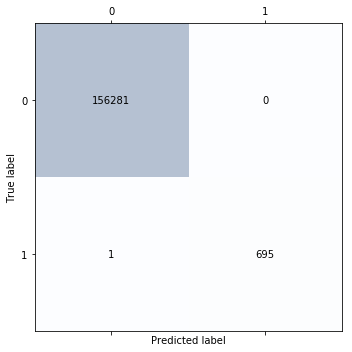

In [19]:
confmat_test = confusion_matrix(ytest_l, clf_l.predict(Xtest_l))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [20]:
TN_test = cm_test[0][0];TP_test = cm_test[1][1];FP_test = cm_test[0][1]; FN_test = cm_test[1][0]

In [21]:
pd.set_option('precision', 3)

TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

In [22]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(ytest_l, clf_l.predict(Xtest_l)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    156281
          1       1.00      1.00      1.00      1.00      1.00      1.00       696

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    156977



**Precision-Recall Curve of test data **

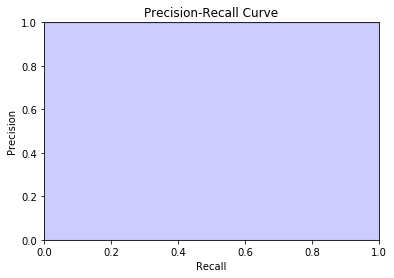

In [23]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(ytest_l, yscore_1)

plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')

**Receiver Operating Characteristic (ROC) of test data**

In [24]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, _ = roc_curve(ytest_l, yscore_1)
roc_auc = auc(fpr1, tpr1)
#print(fpr)

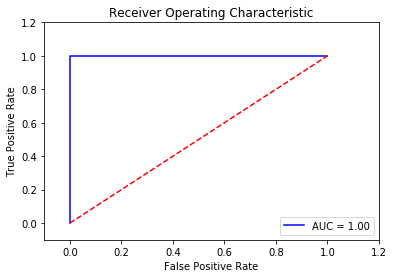

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Confusion matrix of training data**

In [26]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l))
print(cm_train)
cmt_train = pd.DataFrame(cm_train)

[[1406650       0]
 [      1    6134]]


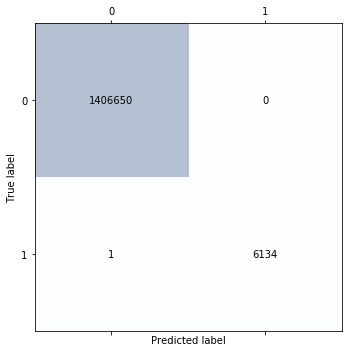

In [27]:
confmat_train = confusion_matrix(ytrain_l, clf_l.predict(Xtrain_l))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [28]:
TN_train = cm_train[0][0];TP_train = cm_train[1][1];FP_train = cm_train[0][1]; FN_train = cm_train[1][0]

In [29]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

In [30]:
print(classification_report_imbalanced(ytrain_l, clf_l.predict(Xtrain_l)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00   1406650
          1       1.00      1.00      1.00      1.00      1.00      1.00      6135

avg / total       1.00      1.00      1.00      1.00      1.00      1.00   1412785



In [31]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [32]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [33]:

performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.004,0.996,1412785,1.0,1.0,1.0,1.0
Test Set,0.004,0.996,156977,1.0,0.999,1.0,1.0


**Feature Importance**

In [34]:
coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(clf_l.coef_))], axis = 1)

In [35]:
coefficients.columns = ['attributes','coefficient']
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()

In [36]:
coefficients.sort_values(by='abs_coefficient', ascending=False).head(20)

,attributes,coefficient,abs_coefficient
197,MANNER_8,-5.078,5.078
551,UC0D_K928,-5.078,5.078
196,MANNER_7,-1.794,1.794
195,MANNER_5,1.148,1.148
284,UCODR130_122,0.589,0.589
4,AB_NICU,0.585,0.585
853,UC0D_R739,0.395,0.395
295,UCODR130_133,0.395,0.395
194,MANNER_4,0.390,0.390
7,APGAR5,-0.337,0.337


**Summary** </br> The performance of the classifier, using sklearn’s imbalanced classification report to take the effect of data imbalance into consideration, are shown above. The results raise suspicion, as even the best classifiers are not expected to perform perfectly. An imbalance in data might explain near perfect scores in accuracy, but not the other metrics such as recall. Rather, perfect scores might indicate the presence of features that act as proxies to the target labels. For example, in the common instance of using height and weight of individuals to classify them to males and females, a third attribute (such as level of testosterone) may serve as proxy to the output labels increasing the overall performance of the classifier but significantly diminishing the weight of the height and weight. In this project, four attributes, ICD code for infant death (UC0D), cause of infant death recode (UCODR130), place of death and manner of death are linked to the positive class (infant death) only. In the dataset, these attributes have a range of values for infant death records but one constant value for surviving infants. Therefore, these four attributes, if they have any value different from the constant for surviving infants, can act as proxies for the positive class. This proposition is supported by their high coefficients observed in feature importance analysis 